<a href="https://colab.research.google.com/github/nikorose87/USB_DL_projects/blob/main/BFP_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Body Fat Percentage Predictor (BFPP)

## Code description

In the following code process, a Body Fat Percentage Prediction is developed using kinematic marker trajectories on overground walking as input features. The dataset used for this prediction can be found in [Horst et al.](https://data.mendeley.com/datasets/svx74xcrjr/3).

The dataset used consists on kinematic trajectory information of 54 different body markers at each instance of gait cycle [from gait start (0%) to full gait (100%)] along 3 axes (X,Y,Z) for 57 subjects, with each subject performing 20$\pm$2 gait trials. 


Each gait trial information will be considered as a sample for the desgined regressor [rows], and its corresponding trajectory marker information as sample features [columns]. This means that input data array for the regressor will have:
* 57 subjects x 20$\pm$2 gait trials $\approx$ 1140 rows
* 100 gait cycle percentages x 54 markes x 3 axes = 16200 columns

The code is divided into three sections:
1. Input features preparation: In this part, the raw dataset is uploaded and processed in order to obtain input_features array as described above.
2. Target data preparation: Target body fat percentage is calculated for each sample using the equation developed by [Gallagher et al.](https://academic.oup.com/ajcn/article/72/3/694/4729363)
3. Body fat percentage prediction: A regressor is trained and tested using input_features and target_body_fat_percentage. Regressor performance is shown with a predicted values vs MSE per sample plot and Bland-Altman plot.

## Data 

In this study, the data from fifty-seven healthy and active subjects ($29$ females, $28$ males; $23.1 \pm 2.7$ years; $1.74 \pm 0.10$ m; $67.9 \pm 11.3$ kg) participated in the study. Each participant performed $20 \pm 2$ gait trials.In time domain dynamic information was stored in structured biomechanical formats (.tsv and .c3d) by trial.

We processed the data as follows: firstly, gait events (heel strike and toe off) were detected in the right limb by implementing the algorithms proposed in \cite{Zeni2008}. Then, We expressed each trial as a function of the gait cycle percentage (GC\%). A polynomial interpolation was performed over the time domain function in order to be adjusted to $m_i \in\mathbb{R}^{1\times 101}$ GC\% vector per $i$ trial. The coefficient of determination ($R^2$) of each interpolation was determined to evaluate the goodness of fit.
%
The resulting dataset was structured in a matrix $M_1 \in\mathbb{R}^{101 \times 57 \times 22\pm 2 \times 54 \times 3}$ as: rows represent the $101$ GC\%, and columns were multi-labeled in four levels by: the subject ID (from 1 to 57), the trial number, the marker label (a total of 54 markers) and coordinate axe (X, Y or Z), from the top to the bottom level, respectively. 

Finally, the data was rearranged in order to organize each trial with their corresponding features. In other words, a matrix $M_2 \in\mathbb{R}^{1142\times16362}$ was processed, placing trials as independent samples with their corresponding features that include: the 101 GC\% frames on each coordinate (X, Y and Z) for all 54 markers available. A total of 16362 characteristics (columns) as features were analyzed.  


## Importing libraries and donwloading the data

In [15]:
#Installing some libraries
!pip install deap update_checker tqdm stopit xgboost
!pip install tpot
!pip install scikit-optimize
!wget -O Horst_markers_raw.csv https://www.dropbox.com/s/fqmnasybxncd4om/Horst_markers_raw.csv?dl=0
!wget -O Gait_subject_info.csv https://www.dropbox.com/s/8ftx0dq92wz4jv2/Gait_subject_info.csv?dl=0

     |████████████████████████████████| 101 kB 3.4 MB/s 
--2021-09-30 23:45:38--  https://www.dropbox.com/s/fqmnasybxncd4om/Horst_markers_raw.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fqmnasybxncd4om/Horst_markers_raw.csv [following]
--2021-09-30 23:45:39--  https://www.dropbox.com/s/raw/fqmnasybxncd4om/Horst_markers_raw.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3e950976f29432226dc0c5faea.dl.dropboxusercontent.com/cd/0/inline/BXIF9bg4cc48Sq7so99KovIrCA8ZIFr1xvg1oQ3wd1Gm8K6CPiyvWUOCMg8v2kNN0rCGlQRQ2U5ZZyk1YZA0UStBdhanldaXnXGsT8bgI3ovp36SyZRPZp0Yz-jFBUR6NrPBV7g179y9lUpNT2KX8UfW/file# [following]
--2021-09-30 23:45:39--  https://uc3e950976f29432226dc0c5faea.dl.dropboxusercontent.com/cd/0/inlin

In [38]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoLarsCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive
from sklearn.metrics import mean_squared_error, r2_score
from skopt import BayesSearchCV
from matplotlib import pyplot as plt
import statsmodels.api as sm

In [17]:
#Loading the preprocessed dataset
marker_data = pd.read_csv('Horst_markers_raw.csv',sep=',', header=[0,1], index_col=[0],
                          low_memory=False)
marker_data.head()

Label,HEAD_ANT,R_HEAD,L_HEAD,C7,R_BACK,L_BACK,STERNUM,R_ACROMION,R_HUM_PROX,R_HUM_ANT,R_HUM_POST,R_ELBOW_LAT,R_ELBOW_MED,R_FOREARM,R_WIRST_LAT,R_WRITS_MED,R_HAND,L_ACROMION,L_HUM_PROX,L_HUM_ANT,L_HUM_POST,L_ELBOW_LAT,L_ELBOW_MED,L_FOREARM,L_WRIST_LAT,L_WIRST_MED,L_HAND,R_ILIAC,SACRUM,L_ILIAC,R_GTROCH,R_THIGH__1,R_THIGH_2,R_THIGH_3,R_THIGH_4,R_SHANK_1,R_SHANK_2,R_SHANK_3,R_SHANK_4,R_HEEL,...,R_WIRST_LAT,R_WRITS_MED,R_HAND,L_ACROMION,L_HUM_PROX,L_HUM_ANT,L_HUM_POST,L_ELBOW_LAT,L_ELBOW_MED,L_FOREARM,L_WRIST_LAT,L_WIRST_MED,L_HAND,R_ILIAC,SACRUM,L_ILIAC,R_GTROCH,R_THIGH__1,R_THIGH_2,R_THIGH_3,R_THIGH_4,R_SHANK_1,R_SHANK_2,R_SHANK_3,R_SHANK_4,R_HEEL,R_FOOT_LAT,R_FOOT_MED,L_GTROCH,L_THIGH_1,L_THIGH_2,L_THIGH_3,L_THIGH_4,L_SHANK_1,L_SHANK_2,L_SHANK_3,L_SHANK_4,L_HEEL,L_FOOT_LAT,L_FOOT_MED
Coordinate,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,S01_0002_Gait,...,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2,S57_0021_Gait.2
0.0000,270.050262,211.661209,210.557236,69.606400,-2.943254,-0.339045,244.528656,140.405914,82.583321,135.741058,14.904850,53.642059,42.050766,140.328629,179.957397,106.595268,168.247452,154.411209,148.064453,215.867752,98.007645,165.196442,109.477821,306.627960,349.475220,314.290924,401.313110,151.643860,13.967046,121.080719,117.333122,231.083817,279.837799,314.955505,252.236679,329.189056,387.666199,418.663025,358.905609,412.902588,...,839.965942,849.018494,763.924866,1471.016968,1299.208740,1217.460815,1214.744629,1134.448975,1110.089355,1000.498230,941.099976,918.198303,874.657471,1019.910706,1011.101318,1049.002930,888.905945,690.557983,702.458801,629.321289,601.747803,346.085999,348.078400,267.576721,248.655502,32.873363,71.357643,99.542641,931.218689,690.577637,715.500854,615.424194,611.522461,315.045135,350.561127,256.796722,239.967468,78.590820,22.378628,30.178619
0.0101,285.446186,227.049177,226.434045,85.430429,12.711996,15.301038,260.429231,156.047494,97.995771,151.213162,30.551311,69.398047,58.085653,155.603114,195.828930,121.803926,182.940956,170.585447,163.749626,231.362212,113.546094,180.508802,124.908187,321.627195,364.635305,329.156468,416.309481,167.159376,29.948755,135.759732,134.173033,250.502654,298.929931,335.002009,272.517247,347.088703,405.542196,435.499735,375.360305,426.478241,...,837.987416,847.648573,761.974277,1469.882557,1298.105844,1216.704520,1213.540342,1133.457846,1108.659818,1000.694493,942.058484,918.437692,875.877538,1018.298201,1009.658157,1047.106593,887.535811,689.686824,701.881337,628.859601,600.954021,345.864604,347.181285,266.177646,247.789170,31.316677,71.587999,96.960664,929.601486,689.137547,714.641528,614.852197,610.174425,315.128635,351.164349,259.249522,241.128280,83.530905,22.520306,30.169151
0.0202,300.966986,242.803931,241.743536,101.422452,28.661478,31.352914,276.527252,171.890510,113.819234,167.219754,46.444456,85.623958,74.333569,171.411847,211.833710,137.439044,198.030672,186.762967,179.436149,246.7198

In [18]:
subject_info = pd.read_csv('Gait_subject_info.csv',sep=';', decimal=',', index_col=[0])
sublabels = ['Gender', 'Age', 'Body Mass', 'Height']
subject_info.columns = sublabels
subject_info.head()

,Gender,Age,Body Mass,Height
subject_id [number],,,,
S01,0,29,68.9,1.75
S02,1,21,64.9,1.81
S03,0,21,80.8,1.84
S04,0,23,82.7,1.82
S05,1,26,54.9,1.63


In [19]:
#Fixing a mistake in labelling the level 1
marker_col_0 = list(marker_data.columns.get_level_values(0).unique())
new_marker_col_0 = ['{}_{}'.format(i,j) for i in marker_col_0 for j in ['X', 'Y', 'Z']]
marker_col_1 = list(marker_data.columns.get_level_values(1))
marker_col_1 = [i[:13] for i in marker_col_1]
marker_col_1 = set(marker_col_1)
new_cols = pd.MultiIndex.from_product([new_marker_col_0,list(marker_col_1)])
marker_data.columns = new_cols

#Letting trials being the samples

marker_data_new = marker_data.T
marker_data_new = marker_data_new.unstack(level=0)

#Reconstucting the index in order to establish the label
subjects = [i[:3] for i in marker_data_new.index]
trials = [i[5:8] for i in marker_data_new.index]
new_idx = pd.MultiIndex.from_arrays([subjects, trials])
marker_data_new.index = new_idx


for i in sublabels:
    marker_data_new[i] = 0

idx = pd.IndexSlice
for ind in subject_info.index:
    for num, j in enumerate(sublabels):
        marker_data_new.loc[idx[ind,:], j] = subject_info.loc[ind, subject_info.columns[num]]

marker_data_new['BMI'] = marker_data_new['Body Mass'] / np.power(marker_data_new['Height'],2)

#Formula to be applied BF% = 76.0 - 1097.8 * (1/BMI) - 20.6 * sex
       # + 0.053 * age + 154 * sex * (1/BMI)
       # + 0.034 * sex * age
      
#Replacing males as ones a females as 0
marker_data_new['Gender'] = marker_data_new['Gender'] -1
marker_data_new['Gender'] = marker_data_new['Gender'].replace(-1, 1)

BFP_formula = lambda age, bmi, sex: 76.0 - 1097.8 * (1/bmi) - 20.6 * \
    sex + 0.053 * age + 154 * sex * (1/bmi) + 0.034 * sex * age

marker_data_new['BFP'] = BFP_formula(marker_data_new.Age,
                                     marker_data_new.BMI,
                                     marker_data_new.Gender)

#Describe in the paper some data about max (32.12) and mins (9.40) in BFP

# =============================================================================
# Performing the ML model
# =============================================================================

marker_data_new = marker_data_new.dropna(axis=1)
#Mention that features are reduced from 16200 to 14300
marker_data_new

0.0                            ... Height        BMI        BFP
               C7_X         C7_Y         C7_Z  ...                             
S01 002  144.382477   116.527733  -257.285278  ...   1.75  22.497959  15.972528
    003  335.271606   880.950073     9.455317  ...   1.75  22.497959  15.972528
    004  160.480972   369.038757    64.499222  ...   1.75  22.497959  15.972528
    005  -86.281960    32.856083  1052.915894  ...   1.75  22.497959  15.972528
    006  431.745392  1230.571289  -109.106544  ...   1.75  22.497959  15.972528
...             ...          ...          ...  ...    ...        ...        ...
S57 017  452.817627    18.416857   109.638802  ...   1.85  22.717312  15.507592
    018  548.547546   425.431854  1379.756104  ...   1.85  22.717312  15.507592
    019  -82.824242   423.423462   922.281982  ...   1.85  22.717312  15.507592
    020  280.196655  1057.663086   125.005630  ...   1.85  22.717312  15.507592
    021  255.652069  1201.133911  -196.051208  ...   1.85  22.717312  15.507592

[1142 rows x 14306 columns]

In [20]:

#Droppiing the sublabels
marker_data_new = marker_data_new.drop(sublabels, axis=1)

train_features, test_features, train_target, test_target = train_test_split(marker_data_new.iloc[:,:-1],
                                                                            marker_data_new['BFP'],
                                                    train_size=0.8, test_size=0.2, random_state=42)


#The base algorithm 
exported_pipeline = make_pipeline(
    PCA(iterated_power=2, svd_solver="randomized"),
    StackingEstimator(estimator=XGBRegressor(learning_rate=0.001, max_depth=5, 
                                             min_child_weight=11, n_estimators=100, 
                                             n_jobs=-1, objective="reg:squarederror", 
                                             subsample=1.0, verbosity=0)),
    LassoLarsCV(normalize=False))

set_param_recursive(exported_pipeline.steps, 'random_state', 0)

exported_pipeline.fit(train_features, train_target)

prediction = exported_pipeline.predict(test_features)
print("MSE = "+str(mean_squared_error(test_target, prediction)))
print("R2 = "+str(r2_score(test_target, prediction)))

MSE = 32.85519704308575
R2 = -0.0047652064571630515


In [ ]:
# search over different model types
pipe = Pipeline([('PCA', PCA()), ('XGB', XGBRegressor(
        n_jobs = -1,
        objective = 'reg:squarederror',
        eval_metric = 'rmse',
        silent=1,
        tree_method='approx'
    ))])

# single categorical value of 'model' parameter is
# sets the model class
# We will get ConvergenceWarnings because the problem is not well-conditioned.
# But that's fine, this is just an example.
PCA_spaces = {
    'PCA__n_components': (2,10)
}

XGB_spaces = {
        'XGB__learning_rate': (0.01, 1.0, 'log-uniform'),
        'XGB__child_weight': (0, 10),
        'XGB__max_depth': (0, 50),
        'XGB__max_delta_step': (0, 20),
        'XGB__subsample': (0.01, 1.0, 'uniform'),
        'XGB__colsample_bytree': (0.01, 1.0, 'uniform'),
        'XGB__colsample_bylevel': (0.01, 1.0, 'uniform'),
        'XGB__reg_lambda': (1e-9, 1000, 'log-uniform'),
        'XGB__reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'XGB__gamma': (1e-9, 0.5, 'log-uniform'),
        'XGB__min_child_weight': (0, 5),
        'XGB__n_estimators': (50, 100),
        'XGB__scale_pos_weight': (1e-6, 500, 'log-uniform')
    }

#Regressor
bayes_cv_tuner = BayesSearchCV(
    estimator = pipe, 
    search_spaces = [PCA_spaces, XGB_spaces],
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    n_iter = 15,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    """Status callback during bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nMin RMSE: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")
  
# Fit the model
result = bayes_cv_tuner.fit(train_features.values, train_target.values, callback=status_print)

Model #1
Min RMSE: -42.9225
Best params: OrderedDict([('PCA__n_components', 9)])

Model #2
Min RMSE: -42.9225
Best params: OrderedDict([('PCA__n_components', 9)])

Model #3
Min RMSE: -42.9225
Best params: OrderedDict([('PCA__n_components', 9)])

Model #4
Min RMSE: -42.9225
Best params: OrderedDict([('PCA__n_components', 9)])

Model #5
Min RMSE: -42.9225
Best params: OrderedDict([('PCA__n_components', 9)])

Model #6
Min RMSE: -42.9225
Best params: OrderedDict([('PCA__n_components', 9)])

Model #7
Min RMSE: -42.9225
Best params: OrderedDict([('PCA__n_components', 9)])

Model #8
Min RMSE: -42.7608
Best params: OrderedDict([('PCA__n_components', 10)])

Model #9
Min RMSE: -42.7608
Best params: OrderedDict([('PCA__n_components', 10)])

Model #10
Min RMSE: -42.7608
Best params: OrderedDict([('PCA__n_components', 10)])



/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #11
Min RMSE: -42.7608
Best params: OrderedDict([('PCA__n_components', 10)])



/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #12
Min RMSE: -42.7608
Best params: OrderedDict([('PCA__n_components', 10)])

Model #13
Min RMSE: -42.7608
Best params: OrderedDict([('PCA__n_components', 10)])



/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #14
Min RMSE: -42.7608
Best params: OrderedDict([('PCA__n_components', 10)])



/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


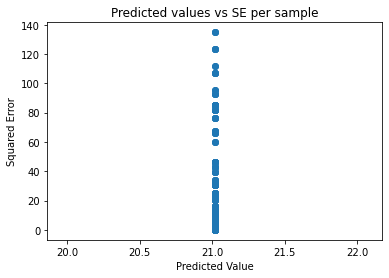

In [10]:
errors = list()
for i in range(len(prediction)):
    err = (test_target[i] - prediction[i])**2
    errors.append(err)
plt.scatter(prediction, errors)
plt.xlabel('Predicted Value')
plt.ylabel('Squared Error')
plt.title('Predicted values vs SE per sample')
plt.show()

In [11]:
test_target = test_target[:,np.newaxis]
prediction = prediction[:,np.newaxis]
errors = np.asarray(errors).reshape((227,1))
results_df = pd.DataFrame(data=np.hstack((test_target,prediction,errors)),columns=['Test target BF%', 'Predicted BF%', 'SE'])

f, ax = plt.subplots(1, figsize = (7,5))
sm.graphics.mean_diff_plot(test_target, prediction, ax = ax)
plt.title('Mean difference plot')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


ValueError: ignored